In [1]:
import csv
import pandas as pd
import numpy as np
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
from functools import reduce
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm

In [2]:
file_names = sorted(glob.glob('/Users/davidchen/Documents/GitHub/Topology/amc_topology/Dataset/*.csv', recursive=True))

In [3]:
unique_sites = [x.strip() for x in list(set([x.split("/")[-1].split("-")[0] for x in file_names]))]

# Function

In [72]:
site = "Utah Healthcare"
name = site
files_matching_name = [s for s in file_names if site in s]

In [73]:
node = [s for s in files_matching_name if "Node" in s][0]
edge = [s for s in files_matching_name if "Internal" in s][0]

In [74]:
topology(name = name, 
                     node = node, 
                     edge = edge)

In [75]:
for site in tqdm(unique_sites):
    name = site
    files_matching_name = [s for s in file_names if site in s]

    node = [s for s in files_matching_name if "Node" in s][0]
    edge = [s for s in files_matching_name if "Internal" in s][0]

    if os.path.isfile(name + "_node_metrics.tsv"):
        print("Topology Analysis already complete: " + str(name))
    else:
        if (len(node) > 0) & (len(edge) > 0):
            try:
                topology(name = name, 
                     node = node, 
                     edge = edge)
            except:
                print("Failed Topology Analysis: " + str(name))
        else:
            print("No Nodes or Edges Detected: " + str(name))

  0%|                                                    | 0/40 [00:00<?, ?it/s]

Topology Analysis already complete: UW Health
Topology Analysis already complete: Utah Healthcare
Topology Analysis already complete: UC Davis
Topology Analysis already complete: Kaleida Health
Topology Analysis already complete: CU Medicine
Topology Analysis already complete: JPS Health
Topology Analysis already complete: Western Health
Topology Analysis already complete: Navicent Health
Topology Analysis already complete: Augusta Health
Topology Analysis already complete: Howard
Topology Analysis already complete: Marshall
Topology Analysis already complete: Tulane
Topology Analysis already complete: RFU Clinics
Topology Analysis already complete: VCU Health
Topology Analysis already complete: VUMC
Topology Analysis already complete: Duke Health
Topology Analysis already complete: Keck Medicine
Topology Analysis already complete: ETSU Health
Topology Analysis already complete: Downstate
Topology Analysis already complete: University of California
Topology Analysis already complete: G

100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 12.20it/s]


In [61]:
def topology(name, node, edge):
    
    #Read Data 

    with open(node, 'r') as nodecsv: # Open the file
        nodereader = csv.reader(nodecsv) # Read the csv
        # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
        nodes = [n for n in nodereader][1:]

    node_names = [n[0] for n in nodes] # Get a list of only the node names

    with open(edge, 'r') as edgecsv: # Open the file
        edgereader = csv.reader(edgecsv) # Read the csv
        edges = [tuple(e[0:2]) for e in edgereader][1:] # Retrieve the data
        edges = [x for x in edges if x[0] != x[1]] # Remove circular edges; link to itself

    #Build Network

    G = nx.Graph()
    G.add_nodes_from(node_names)
    G.add_edges_from(edges)

    #Remove isolated components

    connected_components_size = [len(x) for x in nx.connected_components(G)]
    if len(connected_components_size) == 1:
        isolated_n = 0
    else:
        isolated_n = max(n for n in connected_components_size if n!=max(connected_components_size))

    G.remove_nodes_from(list(nx.isolates(G)))

    for component in list(nx.connected_components(G)):
        if len(component)<=isolated_n:
            for node in component:
                G.remove_node(node)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    #Network-wide metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    diameter = nx.diameter(G)
    transitivity = nx.transitivity(G)
    avg_clustering = nx.average_clustering(G)

    network_df = pd.DataFrame(columns = ['Name', 'Nodes', 'Edges', 'Density', 'Diameter', 'Transitivity', 'Average Clustering'])       
    network_df.loc[len(network_df), :] = [name, n_nodes, n_edges, density, diameter, transitivity, avg_clustering]

    if os.path.isfile("summary_network_metrics.tsv") is True:
        network_df.to_csv("summary_network_metrics.tsv", sep="\t", header=False, index=False, mode="a")
    else:
        network_df.to_csv("summary_network_metrics.tsv", sep="\t", index=False, mode="w")

    #Node-specific metrics
    betweenness = nx.betweenness_centrality(G, normalized=False)
    eigenvector = nx.eigenvector_centrality_numpy(G)
    closeness = nx.closeness_centrality(G)
    eccentricity = nx.eccentricity(G)
    pr = nx.pagerank(G, alpha=0.85)

    nx.set_node_attributes(G, betweenness, 'betweenness')
    nx.set_node_attributes(G, eigenvector, 'eigenvector')
    nx.set_node_attributes(G, closeness, 'closeness')
    nx.set_node_attributes(G, eccentricity, 'eccentricity')
    nx.set_node_attributes(G, pr, 'pagerank')

    betweenness_df = pd.DataFrame.from_dict(data = betweenness.items())
    betweenness_df.columns = ['Node', 'Betweenness']

    eigenvector_df = pd.DataFrame.from_dict(data = eigenvector.items())
    eigenvector_df.columns = ['Node', 'Eigenvector']

    closeness_df = pd.DataFrame.from_dict(data = closeness.items())
    closeness_df.columns = ['Node', 'Closeness']

    eccentricity_df = pd.DataFrame.from_dict(data = eccentricity.items())
    eccentricity_df.columns = ['Node', 'Eccentricity']

    pr_df = pd.DataFrame.from_dict(data = pr.items())
    pr_df.columns = ['Node', 'PageRank']

    node_metrics_df = reduce(lambda left,right: pd.merge(left,right,on='Node'), [betweenness_df,  eigenvector_df, closeness_df, eccentricity_df, pr_df])

    node_metrics_df.to_csv(name + "_node_metrics.tsv", sep="\t", index=False)

    #Network Visualization

    plt.figure(1, figsize=(20,20)) 
    nx.draw(G, 
            pos = nx.spring_layout(G,scale=5, iterations=100),
            node_size = [x*10 for x in list(dict(G.degree).values())],
            edgecolors = "black")
    plt.savefig(name + '_network.png', dpi=300)
    plt.close()

# Metrics Visualization

In [76]:
summary_metrics = pd.read_csv("summary_network_metrics.tsv", sep="\t")

/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_55273/2054497914.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_55273/2054497914.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_55273/2054497914.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_55273/2054497914.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_55273/205449791

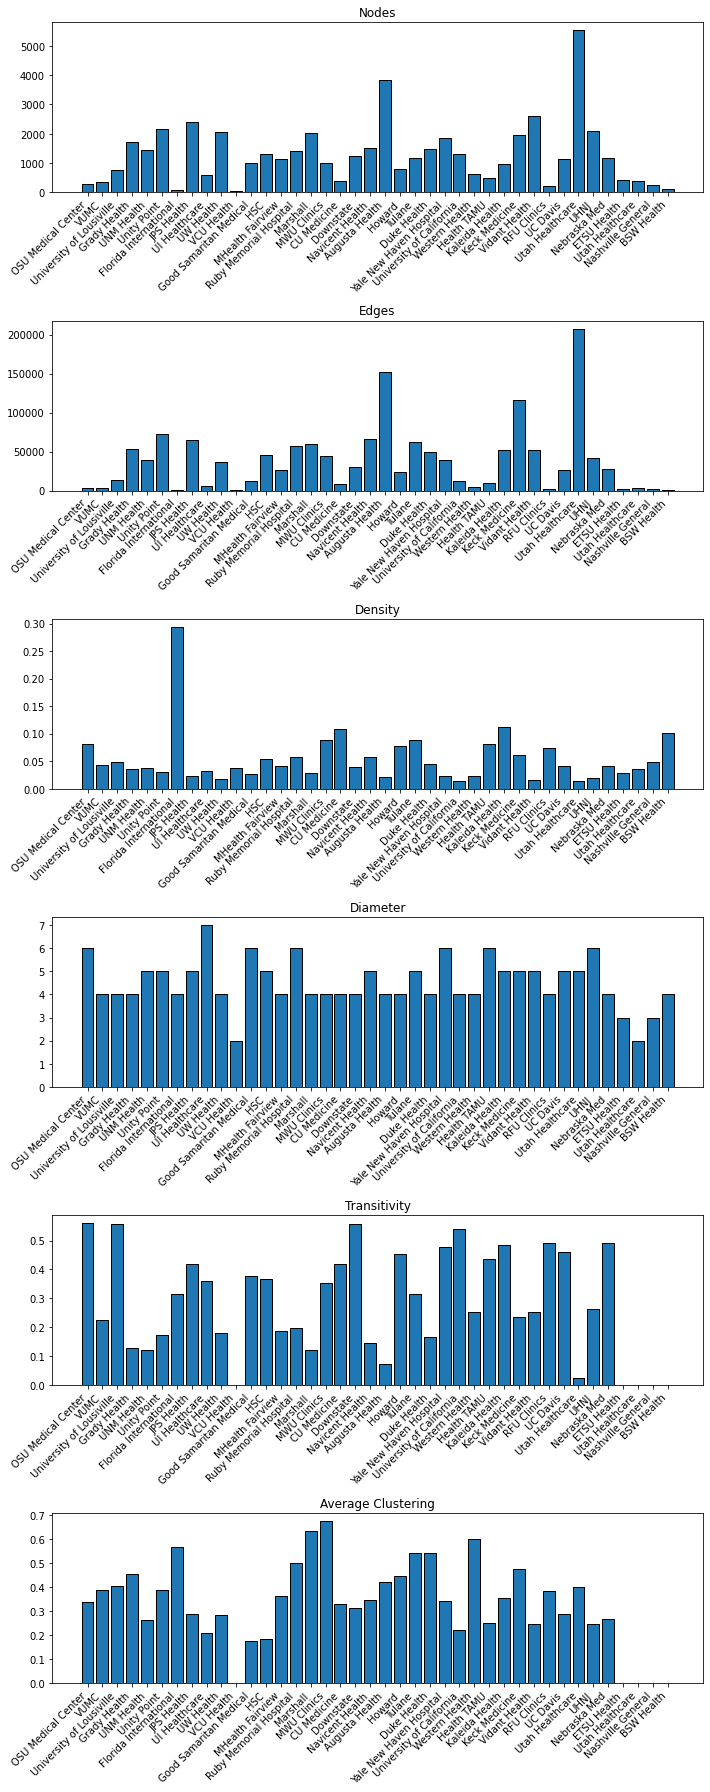

In [77]:
fig, ax = plt.subplots(6, 1, figsize=(10,25))
ax[0].bar(summary_metrics['Name'], summary_metrics['Nodes'], edgecolor="black")
ax[0].set_title("Nodes")
ax[0].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[1].bar(summary_metrics['Name'], summary_metrics['Edges'], edgecolor="black")
ax[1].set_title("Edges")
ax[1].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[2].bar(summary_metrics['Name'], summary_metrics['Density'], edgecolor="black")
ax[2].set_title("Density")
ax[2].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[3].bar(summary_metrics['Name'], summary_metrics['Diameter'], edgecolor="black")
ax[3].set_title("Diameter")
ax[3].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[4].bar(summary_metrics['Name'], summary_metrics['Transitivity'], edgecolor="black")
ax[4].set_title("Transitivity")
ax[4].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[5].bar(summary_metrics['Name'], summary_metrics['Average Clustering'], edgecolor="black")
ax[5].set_title("Average Clustering")
ax[5].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Interactive Network Graph

In [28]:
import plotly.graph_objects as go
import networkx as nx

In [88]:
def build_network(name, node, edge, isolated_n=1):

    #Read Data 
    with open(node, 'r') as nodecsv: # Open the file
        nodereader = csv.reader(nodecsv) # Read the csv
        # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
        nodes = [n for n in nodereader][1:]

    node_names = [n[0] for n in nodes] # Get a list of only the node names
    
    with open(edge, 'r') as edgecsv: # Open the file
        edgereader = csv.reader(edgecsv) # Read the csv
        edges = [tuple(e[0:2]) for e in edgereader][1:] # Retrieve the data
        edges = [x for x in edges if x[0] != x[1]] # Remove circular edges; link to itself
        
    #Build Network
    
    G = nx.Graph()
    G.add_nodes_from(node_names)
    G.add_edges_from(edges)

    #Remove isolated components
    
    G.remove_nodes_from(list(nx.isolates(G)))

    for component in list(nx.connected_components(G)):
        if len(component)<isolated_n:
            for node in component:
                G.remove_node(node)
                
    degree_dict = dict(G.degree(G.nodes()))
    betweenness = nx.betweenness_centrality(G, normalized=False)
    eigenvector = nx.eigenvector_centrality(G)
    closeness = nx.closeness_centrality(G)
    eccentricity = nx.eccentricity(G)
    pr = nx.pagerank(G, alpha=0.85)
    
    nx.set_node_attributes(G, degree_dict, 'degree')
    nx.set_node_attributes(G, betweenness, 'betweenness')
    nx.set_node_attributes(G, eigenvector, 'eigenvector')
    nx.set_node_attributes(G, closeness, 'closeness')
    nx.set_node_attributes(G, eccentricity, 'eccentricity')
    nx.set_node_attributes(G, pr, 'pagerank')
    
    degree_df = pd.DataFrame.from_dict(data = degree_dict.items())
    degree_df.columns = ['Node', 'Degree']
    
    betweenness_df = pd.DataFrame.from_dict(data = betweenness.items())
    betweenness_df.columns = ['Node', 'Betweenness']

    eigenvector_df = pd.DataFrame.from_dict(data = eigenvector.items())
    eigenvector_df.columns = ['Node', 'Eigenvector']

    closeness_df = pd.DataFrame.from_dict(data = closeness.items())
    closeness_df.columns = ['Node', 'Closeness']

    eccentricity_df = pd.DataFrame.from_dict(data = eccentricity.items())
    eccentricity_df.columns = ['Node', 'Eccentricity']

    pr_df = pd.DataFrame.from_dict(data = pr.items())
    pr_df.columns = ['Node', 'PageRank']
    
    node_metrics_df = reduce(lambda left,right: pd.merge(left,right,on='Node'), [degree_df, betweenness_df, eigenvector_df, closeness_df, eccentricity_df, pr_df])
    
    
    pos = nx.spring_layout(G,scale=5, iterations=100),
    
    return G, pos[0], node_metrics_df

In [89]:
G, pos, metrics_df = build_network(name='Nebraska Med',
             node='/Users/davidchen/Documents/GitHub/Topology/amc_topology/Dataset/Nebraska Med - Nodes (Depth = 3).csv',
             edge='/Users/davidchen/Documents/GitHub/Topology/amc_topology/Dataset/Nebraska Med - Internal Edges (Depth = 3).csv')

In [129]:
node_x

[0.07387670874595642,
 0.017441874369978905,
 0.038142502307891846,
 0.027729753404855728,
 0.0035510121379047632,
 0.007922112010419369,
 0.011923328042030334,
 -0.00029867381090298295,
 0.14913542568683624,
 0.02509366162121296,
 0.0735294371843338,
 0.00011339480261085555,
 1.0895711183547974,
 1.3347982168197632,
 0.01806858368217945,
 0.04652460291981697,
 0.006690293084830046,
 -0.760055661201477,
 0.0498100146651268,
 0.024706903845071793,
 0.06302691996097565,
 -0.005604268051683903,
 1.2368487119674683,
 0.059971000999212265,
 -0.45465171337127686,
 0.0013654624344781041,
 0.1696072369813919,
 0.01577368937432766,
 -0.026204660534858704,
 0.029949389398097992,
 0.21795189380645752,
 0.05581352859735489,
 0.007668998092412949,
 0.00559650594368577,
 0.039675693958997726,
 0.10031592100858688,
 0.17100712656974792,
 0.12916038930416107,
 0.08527322858572006,
 0.03481119126081467,
 0.08638085424900055,
 0.00016840477474033833,
 0.6156760454177856,
 0.06152207776904106,
 0.0924289

In [141]:
# edges trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(color='black', width=1),
    hoverinfo='none',
    showlegend=False,
    mode='lines')

# nodes trace
node_x = []
node_y = []
text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    showlegend=False,
    hoverinfo='text',
    marker=dict(
        color='black',
        size=10,
        line=dict(color='black', width=1),
        colorscale='hot',
    colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right')),
    hovertemplate = "<br>Node: %{customdata[0]}<extra></extra>"+\
                    "<br>Degree: %{customdata[1]: .3f}"+\
                    "<br>Betweenness: %{customdata[2]: .3f}"+\
                    "<br>Eigenvector: %{customdata[3]: .3f}"+\
                    "<br>Closeness: %{customdata[4]: .3f}"+\
                    "<br>Eccentricity: %{customdata[5]: .3f}"+\
                    "<br>PageRank: %{customdata[6]: .3f}",
    customdata = np.stack((metrics_df['Node'],
         metrics_df['Degree'],
         metrics_df['Betweenness'],
         metrics_df['Eigenvector'],
         metrics_df['Closeness'],
         metrics_df['Eccentricity'],
         metrics_df['PageRank']), axis =-1))

# layout
layout=go.Layout(plot_bgcolor='white',
                 paper_bgcolor='white',
                 hovermode='closest',
                 showlegend=False,
                 margin=dict(t=10, b=10, l=10, r=10, pad=0),
                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                )

node_adjacencies = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
node_trace.marker.color = node_adjacencies

# figure
fig = go.Figure(data=[edge_trace, node_trace], 
                layout=layout)

#fig.update_layout(title_text='Title')
fig.show()

fig.write_html("/Users/davidchen/Documents/GitHub/Topology/amc_topology/Dataset/example.html")